In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('/Users/Alby/Desktop/rethinking statistics/Rethinking/Data/nettle.csv', 
                sep = ';')

df = df.dropna() 
df.dropna() 

#rename so I can access w dots 
df = df.rename(columns = {'num.lang' : 'numlang', 'k.pop' : 'kpop', 
                    'mean.growing.season' : 'mean_season', 'sd.growing.season' : 'season_std'})

print(df.columns)
df['lpc'] = df.numlang / df.kpop
df['loglpc'] = np.log(df.lpc)
print(df.loglpc)
df['logarea'] = np.log(df['area'])

Index(['country', 'numlang', 'area', 'kpop', 'num.stations', 'mean_season',
       'season_std'],
      dtype='object')
0    -7.262317
1    -5.502521
2    -4.305219
3    -8.073816
4    -4.543499
        ...   
69   -6.652614
70   -7.625758
71   -5.120697
72   -5.442646
73   -6.321867
Name: loglpc, Length: 74, dtype: float64


#### center errthn 

In [3]:
df.loglpc = (df.loglpc - df.loglpc.mean()) 
df.logarea = (df.logarea - df.logarea.mean())
df.mean_season = (df.mean_season - df.mean_season.mean())
df.season_std = (df.season_std - df.season_std.mean())

### multivariate model : mean harvest season time with log(area of civilization) as a covariate

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_1, beta_logarea_1, beta_season_1, alpha_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:03<00:00, 3801.30draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_1,-0.001,0.169,-0.309,0.322,0.002,0.002,9404.0,4479.0,9413.0,6309.0,1.0
beta_season_1,0.143,0.059,0.029,0.250,0.001,0.000,8225.0,8051.0,8207.0,6542.0,1.0
beta_logarea_1,-0.202,0.145,-0.470,0.071,0.002,0.001,7044.0,6384.0,7055.0,5658.0,1.0
sigma_1,1.441,0.126,1.214,1.682,0.001,0.001,8393.0,8302.0,8424.0,5843.0,1.0


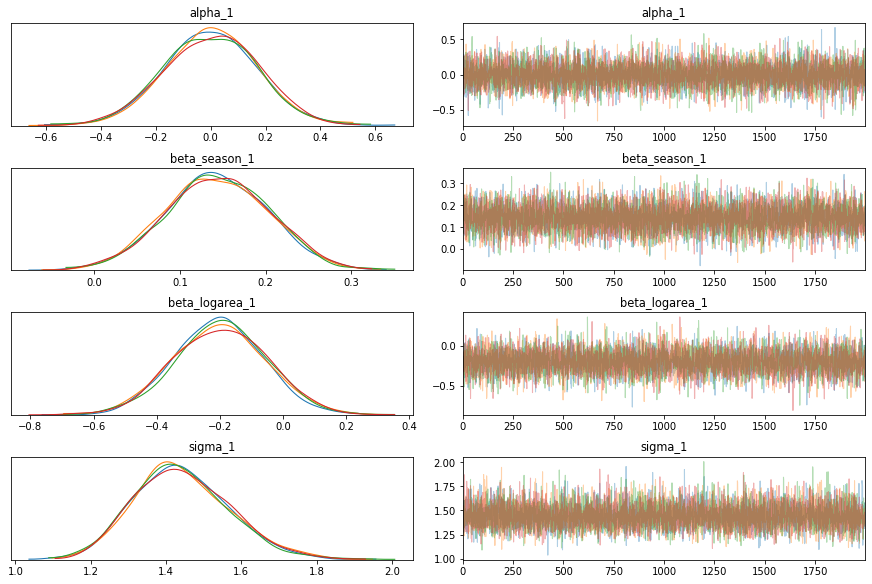

In [4]:
model_1 = pm.Model() 

with model_1 : 
    alpha_1 = pm.Normal('alpha_1', mu = 0, sd = 25)
    beta_season_1 = pm.Normal('beta_season_1', mu = 0, sd = 5) 
    beta_logarea_1 = pm.Normal('beta_logarea_1', mu = 0, sd = 3)
    sigma_1 = pm.HalfCauchy('sigma_1', 3)
    
    mu_1 = pm.Deterministic('mu_1', alpha_1 + beta_season_1 * df.mean_season + beta_logarea_1
                        * df.logarea)
    loglpc_1 = pm.Normal('loglpc_1', mu = mu_1, sd = sigma_1, observed = df.loglpc) 
    trace = pm.sample(2000, tune = 1000)

varnames = ['~mu_1']
az.plot_trace(trace, varnames)
pm.summary(trace, varnames)

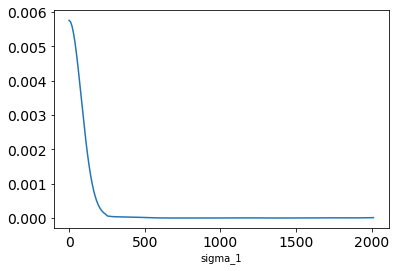

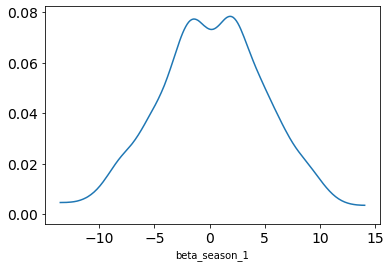

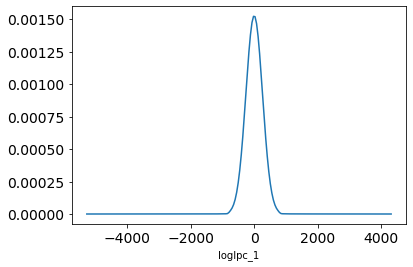

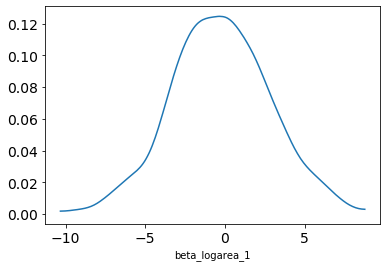

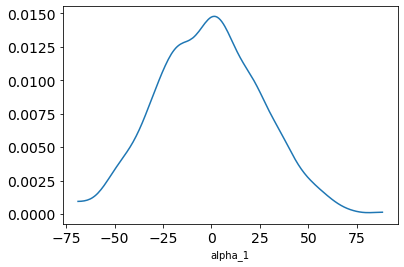

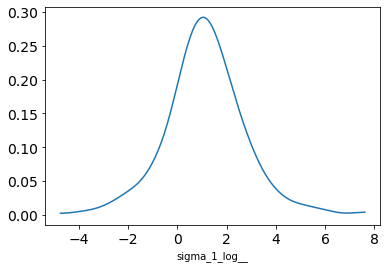

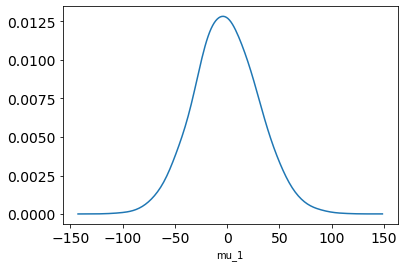

In [10]:
prior_samples = pm.sample_prior_predictive(1000, model_1)
for i in prior_samples :
    plt.figure() 
    az.plot_kde(prior_samples[i])
    plt.xlabel(i) 

-7.041486486486486
4.958513513513514


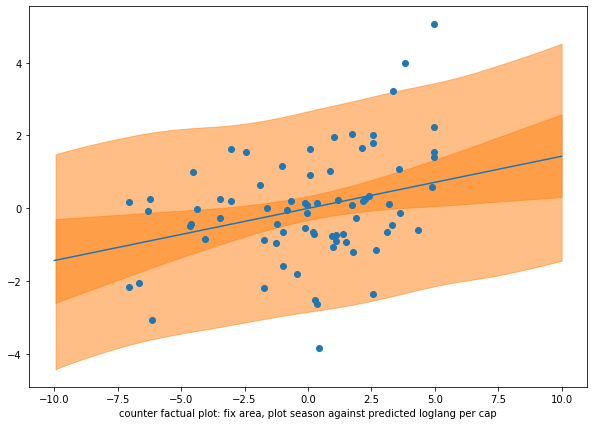

In [11]:
season_seq = np.linspace(-10, 10, 11)
print(df.mean_season.min()) ; print(df.mean_season.max())
season_pred = trace['alpha_1'] + trace['beta_season_1'] * season_seq[:, None] + \
trace['beta_logarea_1'] * df.logarea.mean()

plt.figure(figsize = (10, 7))
plt.plot(df.mean_season, df.loglpc, 'C0o') 
az.plot_hpd(season_seq, season_pred.T)
plt.plot(season_seq, season_pred.mean(1)) 
plt.xlabel('counter factual plot: fix area, plot season against predicted loglang per cap')

az.plot_hpd(season_seq, stats.norm.rvs(season_pred, trace['sigma_1']).T)

/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 966.21it/s]


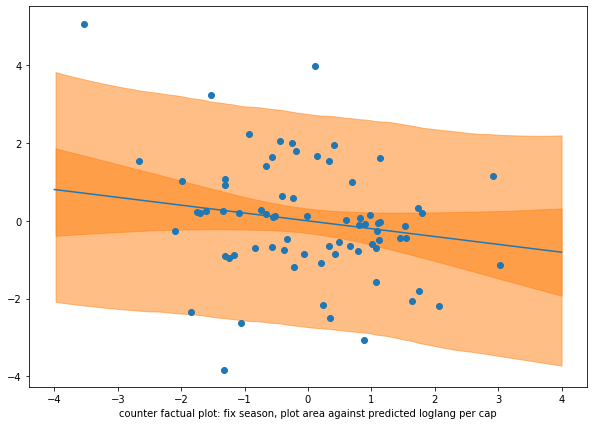

In [12]:
logarea_seq = np.linspace(-4, 4
                          , 100)
area_pred = trace['alpha_1'] + trace['beta_logarea_1'] * logarea_seq[:, None] +\
trace['beta_season_1'] * df.mean_season.mean()

plt.figure(figsize = (10, 7))
plt.plot(df.logarea, df.loglpc, 'C0o') 
az.plot_hpd(logarea_seq, area_pred.T)
plt.plot(logarea_seq, area_pred.mean(1)) 
plt.xlabel('counter factual plot: fix season, plot area against predicted loglang per cap')

post_samples = pm.sample_posterior_predictive(trace, 1000, model_1)

az.plot_hpd(logarea_seq, stats.norm.rvs(area_pred, trace['sigma_1']).T)

### regress season time fluctuation (std) with language div

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_2, beta_2, alpha_2]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4007.56draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_2,-0.003,0.184,-0.325,0.365,0.003,0.003,4291.0,1711.0,4260.0,2570.0,1.0
beta_2,-0.357,0.161,-0.637,-0.043,0.002,0.002,4883.0,4431.0,4894.0,3113.0,1.0
sigma_2,1.502,0.126,1.276,1.740,0.002,0.001,4310.0,4262.0,4318.0,2405.0,1.0


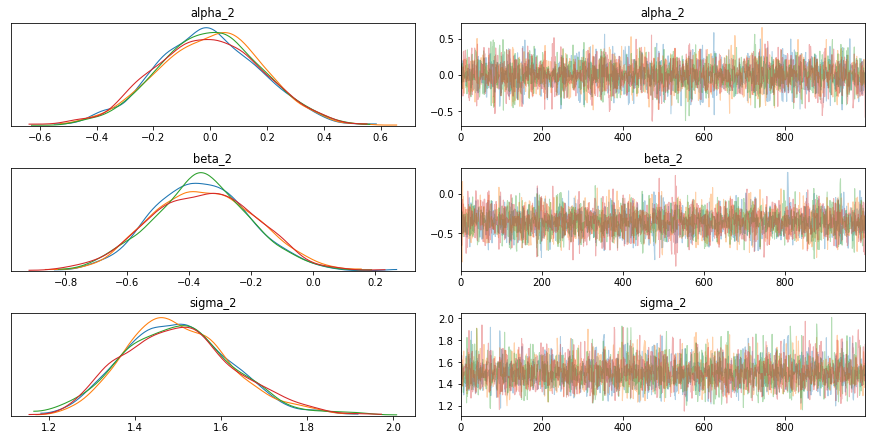

In [146]:
model_2 = pm.Model() 

with model_2 : 
    alpha_2 = pm.Normal('alpha_2', mu = 0, sd = 30)
    beta_2 = pm.Normal('beta_2', mu = 0, sd = 10)
    sigma_2 = pm.HalfCauchy('sigma_2', 2) 
    
    mu_2 = pm.Deterministic('mu_2', alpha_2 + beta_2*df.season_std) 
    loglpc_2 = pm.Normal('loglpc_2', mu = mu_2, sigma = sigma_2, observed = df.loglpc)
    trace_2 = pm.sample(1000, tune = 1000)
    
varnames = ['~mu_2']
az.plot_trace(trace_2, varnames)
pm.summary(trace_2, ['~mu_2'])

/opt/anaconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 990.04it/s]


Text(0.5, 0, 'lang diversity predicted by season std')

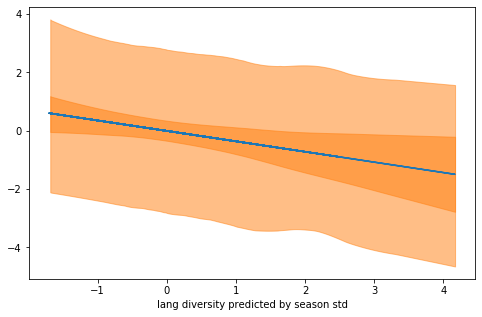

In [188]:
post_samples_2 = pm.sample_posterior_predictive(trace_2, 1000, model_2) 
plt.figure(figsize = (8, 5))
az.plot_hpd(df.season_std, post_samples_2['loglpc_2'])
az.plot_hpd(df.season_std, (trace_2['alpha_2'] + trace_2['beta_2'] * df.season_std[:, None]).T)
plt.plot(df.season_std, (trace_2['alpha_2'] + trace_2['beta_2'] * df.season_std[:, None]).mean(1))
plt.xlabel('lang diversity predicted by season std')

## fit a model looking at mean season time and std plus an interaction

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_3, beta_int_3, beta_seasonstd_3, beta_season_3, alpha_3]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3017.03draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha_3,0.010,0.161,-0.290,0.311,0.003,0.002,4015.0,2326.0,4011.0,2895.0,1.0
beta_season_3,0.113,0.058,0.009,0.222,0.001,0.001,3281.0,3281.0,3282.0,2875.0,1.0
beta_seasonstd_3,-0.347,0.155,-0.633,-0.054,0.002,0.002,4172.0,3970.0,4173.0,3067.0,1.0
beta_int_3,-0.109,0.049,-0.197,-0.012,0.001,0.001,2968.0,2717.0,2989.0,2782.0,1.0
sigma_3,1.367,0.120,1.145,1.592,0.002,0.001,3782.0,3751.0,3800.0,2920.0,1.0


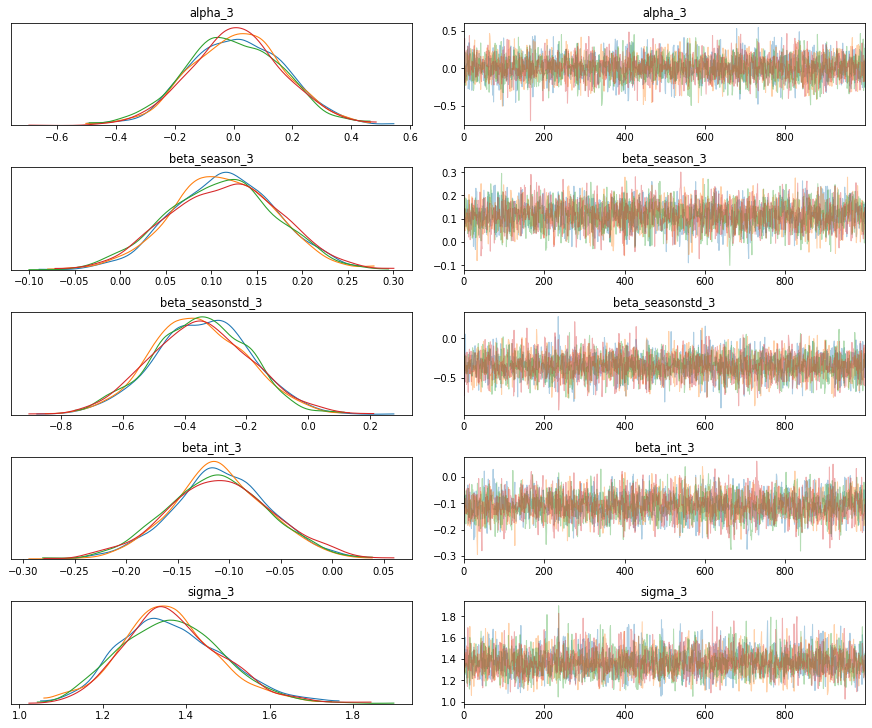

In [189]:
model_3 = pm.Model() 

with model_3 : 
    alpha_3 = pm.Normal('alpha_3', mu = 0, sd = 50)
    beta_season_3 = pm.Normal('beta_season_3', mu = 0, sd = 5)
    beta_seasonstd_3 = pm.Normal('beta_seasonstd_3', mu = 0, sd = 5)
    beta_int_3 = pm.Normal('beta_int_3', mu = 0, sd = 10) 
    sigma_3 = pm.HalfCauchy('sigma_3', 10)
    
    mu_3 = pm.Deterministic('mu_3', alpha_3 + beta_season_3 * df.mean_season +\
                            beta_seasonstd_3 * df.season_std + beta_int_3 * df.season_std *\
                           df.mean_season)
    loglpc_3 = pm.Normal('loglpc_3', mu = mu_3, sd = sigma_3, observed = df.loglpc) 
    trace_3 = pm.sample(1000, tune = 1000) 

az.plot_trace(trace_3, ['~mu_3'])
pm.summary(trace_3, ['~mu_3'])

#### check what values of std and mn season to evaluate over with hist

(array([ 6.,  0.,  7.,  3.,  6., 12., 13., 11.,  9.,  7.]),
 array([-7.04148649, -5.84148649, -4.64148649, -3.44148649, -2.24148649,
        -1.04148649,  0.15851351,  1.35851351,  2.55851351,  3.75851351,
         4.95851351]),
 <a list of 10 Patch objects>)

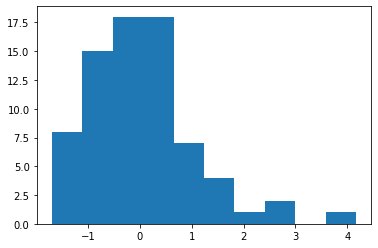

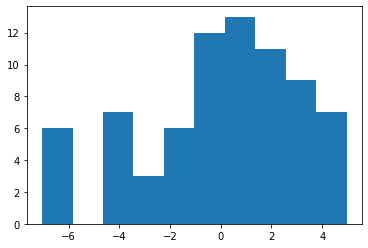

In [190]:
plt.hist(df.season_std) # so let's see the effect over std = [-1, 1] 
plt.figure() 
plt.hist(df.mean_season) #evaluate over [-4, 4]

### estimated plot interactions 

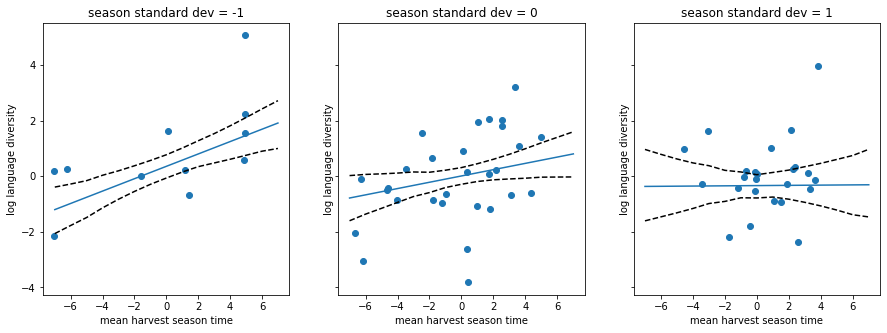

In [204]:
f, axs = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
mu_season = range(-7, 8, 1) #range of season values to evaluate in each iteration of the loop

mu = np.zeros((len(mu_season), len(trace_3['alpha_3']))) #empty vector 

for ax, s in zip(axs, range(-1, 2, 1)) : #iterate over n axes and s range of season_std values 
    d_subset = df.loc[(df['season_std'] <= s) & (df['season_std'] >= s-1)] 
    ax.plot(d_subset.mean_season, d_subset.loglpc, 'C0o')
    for i, season in enumerate(mu_season) : 
        mu[i] = trace_3['alpha_3'] + trace_3['beta_season_3'] * season +\
        trace_3['beta_seasonstd_3'] * s + trace_3['beta_int_3'] * s * season
    mu_hpd = pm.hpd(mu.T)
    mu_mean = mu.mean(1) 
    ax.plot(mu_season, mu_hpd.T[0], 'k--')
    ax.plot(mu_season, mu_hpd.T[1], 'k--')
    ax.plot(mu_season, mu_mean) 
    ax.set_title('season standard dev = {:d}'.format(s))
    ax.set_xlabel('mean harvest season time') 
    ax.set_ylabel('log language diversity')

## information criteria

In [214]:
comparison = az.compare( {'model area & season' : trace, 
                   'model std': trace_2, 
                   'model std & season' : trace_3}, method = 'pseudo-BMA' )

comparison # gives all the fuckin weight! 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model std & season,0,-130.534,5.42947,0,0.965145,7.32102,0,False,log
model area & season,1,-133.926,4.60089,3.39207,0.0324664,7.37257,2.55837,False,log
model std,2,-136.536,3.57034,6.00166,0.00238839,8.02448,3.87892,False,log


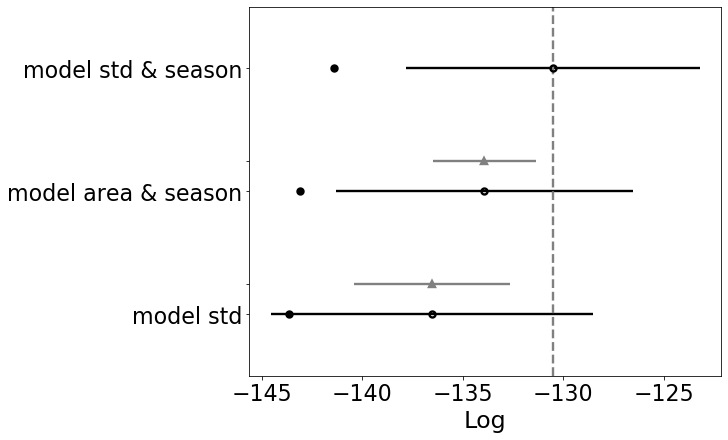

In [215]:

az.plot_compare(comparison, figsize = (10, 6))

In [222]:
tabs = pd.DataFrame({'model area & season' : pm.summary(trace, var_names = ['~mu_1'])['mean'], 
                    'model std' : pm.summary(trace_2, var_names = ['~mu_2'])['mean'], 
                    'model std & season' : pm.summary(trace_3, var_names =  ['~mu_3'])['mean']})

tabs

,model area & season,model std,model std & season
alpha_1,0.001,NaN,NaN
alpha_2,NaN,-0.003,NaN
alpha_3,NaN,NaN,0.010
beta_2,NaN,-0.357,NaN
beta_int_3,NaN,NaN,-0.109
beta_logarea_1,-0.201,NaN,NaN
beta_season_1,0.144,NaN,NaN
beta_season_3,NaN,NaN,0.113
beta_seasonstd_3,NaN,NaN,-0.347
sigma_1,1.439,NaN,NaN
